# Poission Tutorial (Simple)

## Imports

In [1]:
# | code-fold: true
# | code-summary: "Load packages"
# | output: false

import os
import numpy as np
import jax
from jax import numpy as jnp
import pytest
from types import SimpleNamespace
from sympy import cos, pi
from time import time as gettime

from library.python.fvm.solver_jax import PoissonSolver, Settings
from library.python.fvm.ode import RK1
import library.python.fvm.reconstruction as recon
import library.python.fvm.timestepping as timestepping
import library.python.fvm.flux as flux
import library.python.fvm.nonconservative_flux as nc_flux
from library.model.models.poisson import Poisson
from library.model.boundary_conditions import BoundaryCondition
from library.model.models.basisfunctions import Basisfunction, Legendre_shifted
from library.model.models.basismatrices import Basismatrices
from library.python.misc.misc import Zstruct

from library.model.models.poisson import Poisson
import library.model.initial_conditions as IC
import library.model.boundary_conditions as BC
import library.python.misc.io as io
from library.python.mesh.mesh import compute_derivatives
from tests.pdesoft import plots_paper


import library.python.mesh.mesh as petscMesh
import library.postprocessing.postprocessing as postprocessing
from library.python.mesh.mesh import convert_mesh_to_jax
import argparse

2025-08-08 07:54:53.023 | WARNING  | library.python.fvm.solver_jax:<module>:28 - No module named 'precice'


## Solver definition

In [2]:
class MyPoissonSolver(PoissonSolver):
    def update_qaux(self, Q, Qaux, Qold, Qauxold, mesh, model, parameters, time, dt):
        T = Q[0]
        ddTdxx  = compute_derivatives(T, mesh, derivatives_multi_index=([[2]]))[:,0]
        Qaux = Qaux.at[0].set(ddTdxx)
        return Qaux


## Model

In [3]:
settings = Settings(
    output=Zstruct(
        directory="outputs/poisson", filename="poisson", clean_directory=True,
    ),
)

bc_tags = ["left", "right"]
bc_tags_periodic_to = ["right", "left"]

bcs = BC.BoundaryConditions( [
        BC.Lambda(physical_tag='left', prescribe_fields={0: lambda t, x, dx, q, qaux, p, n: 1.}),
        BC.Lambda(physical_tag='right', prescribe_fields={0: lambda t, x, dx, q, qaux, p, n: 2.}),
    ]
)

def custom_ic(x):
    Q = np.zeros(1, dtype=float)
    Q[0] = 0.
    return Q

ic = IC.UserFunction(custom_ic)


model = Poisson(
    boundary_conditions=bcs,
)

mesh = petscMesh.Mesh.create_1d((0., 1.), 300, lsq_degree = 2)

solver = MyPoissonSolver(settings=settings)


2025-08-08 07:54:53.926 | WARNING  | library.python.misc.misc:__init__:136 - No 'solver' Zstruct found in Settings. Default: empty Zstruct
2025-08-08 07:54:53.927 | WARNING  | library.python.misc.misc:__init__:139 - No 'model' Zstruct found in Settings. Default: empty Zstruct
2025-08-08 07:54:53.927 | WARNING  | library.python.misc.misc:__init__:156 - No 'parameters' attribute found in model Zstruct. Default: empty Zstruct


In [4]:
Q, Qaux = solver.solve(
    mesh,
    model,
)

io.generate_vtk(os.path.join(settings.output.directory, f"{settings.output.filename}.h5"))


2025-08-08 07:54:55.639 | DEBUG    | library.python.fvm.solver_jax:log_callback_poisson:51 - Newton iterations: 4, final residual norm: 2.924e-10
2025-08-08 07:54:55.700 | INFO     | library.python.fvm.solver_jax:log_callback_execution_time:55 - Finished simulation with in 0.997 seconds


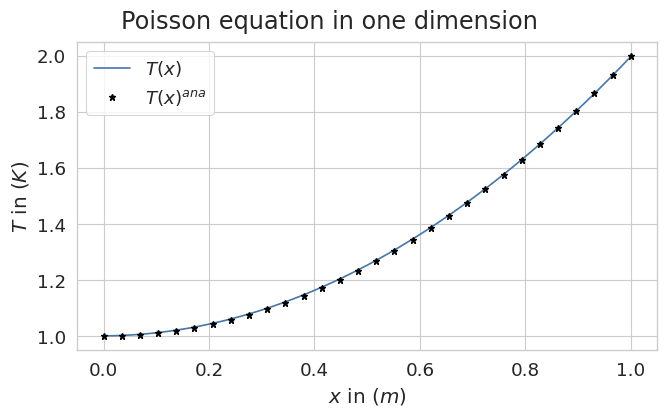

In [5]:
fig = plots_paper.plot_poisson(os.path.join(settings.output.directory, settings.output.filename + ".h5"))